In [4]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import matplotlib.pyplot as plt

In [5]:
import keras
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras import models
from keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import backend as K

In [3]:
import tensorflow as tf

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
tf.test.gpu_device_name()

!nvidia-smi

Tue Mar 23 07:45:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    32W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Data Load & Preprocessing

### 1) Load

In [8]:
(train_data, train_targets), (X_test, y_test) = cifar100.load_data(label_mode = 'fine')

169009152/169001437 [==============================] - 6s 0us/step


### 2) Reshape

In [9]:
train_data = train_data.reshape((50000,  32, 32, 3))
X_test = X_test.reshape((10000,  32, 32, 3))

### 3) One Hot Encoding

In [10]:
train_targets = to_categorical(train_targets)
y_test = to_categorical(y_test)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_targets,
                                                      test_size = 0.2,
                                                      random_state = 2045)
X_train.shape, X_valid.shape

((40000, 32, 32, 3), (10000, 32, 32, 3))

### 4) ImageDataGenerator()

In [12]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest')

train_set = train_generator.flow(X_train, y_train, batch_size = 1000)


# # Witout Augmentation
valid_generator = ImageDataGenerator(rescale = 1. / 255)
valid_set = valid_generator.flow(X_valid, y_valid, batch_size = 1000)

#batch_size는 1000 이상 주지 말것 (gpu 메모리가 감당할 양을 넘어선다)

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',
                        input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=100, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [15]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [17]:
%%time

Hist_mnist = model.fit(train_set,
                       steps_per_epoch = 40,
                       epochs = 50,
                       validation_data = valid_set,
                       validation_steps = 10)

Epoch 1/50
40/40 [==============================] - 57s 630ms/step - loss: 4.5609 - accuracy: 0.0159 - val_loss: 4.3122 - val_accuracy: 0.0392
Epoch 2/50
40/40 [==============================] - 25s 629ms/step - loss: 4.3286 - accuracy: 0.0390 - val_loss: 4.0684 - val_accuracy: 0.0898
Epoch 3/50
40/40 [==============================] - 25s 631ms/step - loss: 4.1470 - accuracy: 0.0636 - val_loss: 3.8774 - val_accuracy: 0.1059
Epoch 4/50
40/40 [==============================] - 25s 626ms/step - loss: 4.0164 - accuracy: 0.0774 - val_loss: 3.7379 - val_accuracy: 0.1271
Epoch 5/50
40/40 [==============================] - 25s 624ms/step - loss: 3.9131 - accuracy: 0.0970 - val_loss: 3.6366 - val_accuracy: 0.1524
Epoch 6/50
40/40 [==============================] - 25s 627ms/step - loss: 3.8243 - accuracy: 0.1082 - val_loss: 3.5796 - val_accuracy: 0.1545
Epoch 7/50
40/40 [==============================] - 25s 624ms/step - loss: 3.7712 - accuracy: 0.1153 - val_loss: 3.4487 - val_accuracy: 0.1800

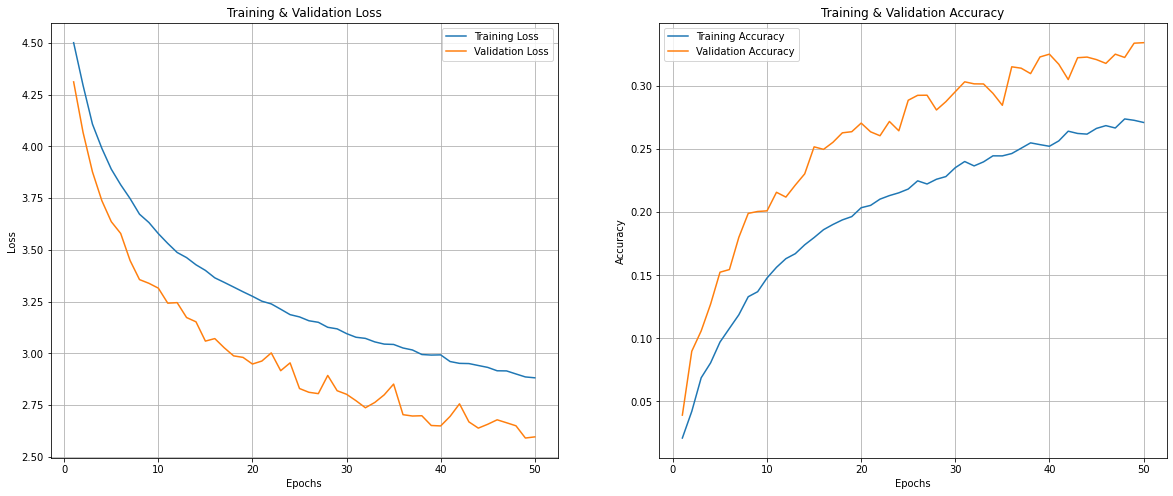

In [21]:
epochs = range(1, len(Hist_mnist.history['loss']) + 1)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_mnist.history['loss'])
plt.plot(epochs, Hist_mnist.history['val_loss'])
# plt.ylim(0, 0.4)
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_mnist.history['accuracy'])
plt.plot(epochs, Hist_mnist.history['val_accuracy'])
# plt.ylim(0, 0.4)
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

In [22]:
test_generator = ImageDataGenerator(rescale = 1. / 255)

test_set = test_generator.flow(X_test, y_test, batch_size = 1000)

In [24]:
loss, accuracy = model.evaluate(test_set)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

10/10 [==============================] - 1s 57ms/step - loss: 2.6169 - accuracy: 0.3263
Loss = 2.61694
Accuracy = 0.32630


In [26]:
model.save('/content/drive/My Drive/Colab Notebooks/models/005_CIFAR100_with_augmentation.h5')

In [27]:
model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/005_CIFAR100_with_augmentation.h5')

In [28]:
loss, accuracy = model_google.evaluate(test_set)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

10/10 [==============================] - 1s 57ms/step - loss: 2.6169 - accuracy: 0.3263
Loss = 2.61694
Accuracy = 0.32630
